# **Week 3 · Lesson 2 — Build & Trace a Mini-Transformer Encoder (2 layers)**

In this lab, you will construct a two-layer Transformer encoder from first principles, then trace shapes and attention maps to verify that each sub-block (multi-head self-attention, Add & LayerNorm, feed-forward network) behaves as expected.

**1) Setup and notebook utilities**

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Reproducibility
torch.manual_seed(42)

# Configuration (feel free to lower D_MODEL=64 and N_HEADS=2 if your device is slow)
BATCH_SIZE = 2     # B
SEQ_LEN    = 6     # S
D_MODEL    = 128   # d_model
N_HEADS    = 4     # number of attention heads
D_FF       = 4 * D_MODEL
VOCAB_SIZE = 2000

# Helper to print shapes and basic stats during the trace
def stats(name, x):
    x_det = x.detach()
    print(f"{name:>22} | shape={tuple(x_det.shape)}  "
          f"min={x_det.min():.4f} max={x_det.max():.4f} mean={x_det.mean():.4f}")


Device: cuda


**2) Positional signal (sinusoidal)**

You will add a deterministic position encoding so the encoder can distinguish word order.

In [2]:
class SinusoidalPositionalEncoding(nn.Module):
    """
    Adds a sinusoidal position signal to token embeddings.
    Input/Output shape: (B, S, d_model)
    """
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)   # (S, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32)
                             * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)   # even indices
        pe[:, 1::2] = torch.cos(position * div_term)   # odd indices
        pe = pe.unsqueeze(0)  # (1, S, d_model)
        self.register_buffer("pe", pe)  # not a trainable parameter

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        S = x.size(1)
        return x + self.pe[:, :S, :]


**3) One encoder layer (MHSA → Add\&Norm → FFN → Add\&Norm)**

You will also collect a \textbf{trace} of intermediate tensors and attention weights.

In [3]:
class MiniEncoderLayer(nn.Module):
    """
    One Transformer encoder layer:
      1) Multi-Head Self-Attention (MHSA)
      2) Add & LayerNorm
      3) Feed-Forward Network (FFN)
      4) Add & LayerNorm
    Returns both the output and a trace dict.
    """
    def __init__(self, d_model: int, n_heads: int, d_ff: int, attn_dropout: float = 0.0, ff_dropout: float = 0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=attn_dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(ff_dropout),
            nn.Linear(d_ff, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, return_attn: bool = True,
                disable_residuals: bool = False,
                disable_ffn: bool = False):
        trace = {}

        # 1) MHSA
        attn_out, attn_w = self.mha(x, x, x, need_weights=True, average_attn_weights=False)
        # attn_w shape: (B, n_heads, S, S)
        trace["mhsa_out"] = attn_out
        trace["attn_w"] = attn_w

        # 2) Add & LayerNorm #1
        if disable_residuals:
            y = self.norm1(attn_out)
        else:
            y = self.norm1(x + attn_out)
        trace["post_attn_norm"] = y

        # 3) FFN
        if disable_ffn:
            ffn_out = torch.zeros_like(y)
        else:
            ffn_out = self.ffn(y)
        trace["ffn_out"] = ffn_out

        # 4) Add & LayerNorm #2
        if disable_residuals:
            z = self.norm2(ffn_out)
        else:
            z = self.norm2(y + ffn_out)
        trace["post_ffn_norm"] = z

        if return_attn:
            return z, trace, attn_w
        return z, trace, None

**4) Two-layer encoder wrapper**

This module embeds token IDs, adds positional encoding, and stacks two encoder layers.

In [4]:
class MiniEncoder(nn.Module):
    """
    Token embedding + positional encoding + stacked encoder layers.
    """
    def __init__(self, vocab_size: int, d_model: int, n_heads: int, d_ff: int, n_layers: int = 2,
                 use_positional_encoding: bool = True):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.posenc = SinusoidalPositionalEncoding(d_model) if use_positional_encoding else nn.Identity()
        self.layers = nn.ModuleList([MiniEncoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)])

    def forward(self, token_ids, return_all_traces: bool = True,
                disable_residuals: bool = False, disable_ffn: bool = False):
        # token_ids: (B, S)
        x = self.embed(token_ids)                 # (B, S, d_model)
        x = self.posenc(x)                        # (B, S, d_model)
        traces = []
        attn_list = []

        for i, layer in enumerate(self.layers, start=1):
            x, trace, attn = layer(x, return_attn=True,
                                   disable_residuals=disable_residuals,
                                   disable_ffn=disable_ffn)
            if return_all_traces:
                traces.append((f"layer_{i}", trace))
                attn_list.append(attn)
        return x, traces, attn_list

**5) Create a toy batch and run a full trace**

You will print tensor shapes and value ranges after each sub-block to confirm the wiring is correct.

In [6]:
# Toy batch of token IDs
token_ids = torch.randint(low=0, high=VOCAB_SIZE, size=(BATCH_SIZE, SEQ_LEN), device=device)

# Build the encoder WITH positional encoding
encoder = MiniEncoder(VOCAB_SIZE, D_MODEL, N_HEADS, D_FF, n_layers=2, use_positional_encoding=True).to(device)

# Forward pass + trace
with torch.no_grad():
    enc_out, traces, attn_list = encoder(token_ids, return_all_traces=True)

print("=== INPUTS ===")
#stats("token_ids", token_ids)

print("\n=== LAYER-BY-LAYER TRACE ===")
for lname, tr in traces:
    print(f"\n-- {lname} --")
    stats("mhsa_out", tr["mhsa_out"])
    stats("post_attn_norm", tr["post_attn_norm"])
    stats("ffn_out", tr["ffn_out"])
    stats("post_ffn_norm", tr["post_ffn_norm"])

print("\n=== ENCODER OUTPUT ===")
stats("enc_out", enc_out)

# Verify attention weights shapes per layer
for i, attn in enumerate(attn_list, start=1):
    print(f"Attention weights L{i}: shape={tuple(attn.shape)}  (B, heads, S, S)")

=== INPUTS ===

=== LAYER-BY-LAYER TRACE ===

-- layer_1 --
              mhsa_out | shape=(2, 6, 128)  min=-1.1203 max=0.8566 mean=-0.0351
        post_attn_norm | shape=(2, 6, 128)  min=-3.7055 max=3.1124 mean=0.0000
               ffn_out | shape=(2, 6, 128)  min=-0.8070 max=0.5523 mean=0.0041
         post_ffn_norm | shape=(2, 6, 128)  min=-3.8996 max=3.0755 mean=-0.0000

-- layer_2 --
              mhsa_out | shape=(2, 6, 128)  min=-0.7672 max=0.6601 mean=0.0310
        post_attn_norm | shape=(2, 6, 128)  min=-3.8655 max=3.1144 mean=0.0000
               ffn_out | shape=(2, 6, 128)  min=-0.7346 max=0.7583 mean=0.0193
         post_ffn_norm | shape=(2, 6, 128)  min=-4.0200 max=3.2664 mean=0.0000

=== ENCODER OUTPUT ===
               enc_out | shape=(2, 6, 128)  min=-4.0200 max=3.2664 mean=0.0000
Attention weights L1: shape=(2, 4, 6, 6)  (B, heads, S, S)
Attention weights L2: shape=(2, 4, 6, 6)  (B, heads, S, S)


**6) Visualize one attention map (S × S)**

You will inspect Layer 1, Head 0 for batch item 0. (Feel free to try other heads/layers.)

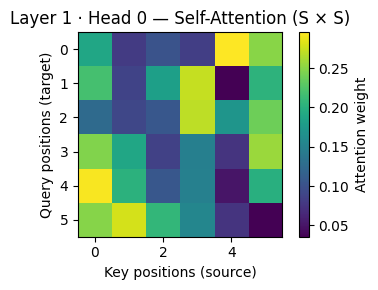

In [7]:
attn = attn_list[0]            # layer 1 attention weights
attn_map = attn[0, 0].cpu()    # (S, S): batch 0, head 0

plt.figure(figsize=(4, 3))
plt.imshow(attn_map)
plt.colorbar(label="Attention weight")
plt.title("Layer 1 · Head 0 — Self-Attention (S × S)")
plt.xlabel("Key positions (source)")
plt.ylabel("Query positions (target)")
plt.tight_layout()
plt.show()


**7) Sanity checks (attention normalization)**

For a self-attention head, weights over the \textbf{key} dimension should sum to \~1.0 for each query.

In [8]:
# Check Layer 1, Head 0, Batch 0
attn = attn_list[0] # (B, heads, S, S)
a = attn[0, 0] # (S, S)
row_sums = a.sum(dim=-1) # sum over key positions
print("Row sums (should be ~1.0 each):", row_sums)
assert torch.allclose(row_sums, torch.ones_like(row_sums), atol=1e-5), "Attention rows do not sum to 1.0!"
print("✓ Attention normalization check passed.")

Row sums (should be ~1.0 each): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')
✓ Attention normalization check passed.


**8) Quick ablations (reason about why each part matters)**

**8a) Remove positional encoding**
You will compare outputs with/without positional signals.

In [10]:
encoder_no_pos = MiniEncoder(VOCAB_SIZE, D_MODEL, N_HEADS, D_FF, n_layers=2, use_positional_encoding=False).to(device)

with torch.no_grad():
    out_with_pos, _, _ = encoder(token_ids)
    out_no_pos,  _, _ = encoder_no_pos(token_ids)

rms_diff_pos = (out_with_pos - out_no_pos).pow(2).mean().sqrt().item()
print(f"RMS difference (with vs without positional encoding): {rms_diff_pos:.6f}")


RMS difference (with vs without positional encoding): 1.378127


**8b) Disable the FFN**

You will zero-out the FFN contribution and compare to baseline.

In [11]:
encoder_ffn_off = MiniEncoder(VOCAB_SIZE, D_MODEL, N_HEADS, D_FF, n_layers=2, use_positional_encoding=True).to(device)

with torch.no_grad():
    baseline, _, _ = encoder(token_ids)
    out_ffn_off, _, _ = encoder_ffn_off(token_ids, disable_ffn=True)

stats("enc_out (FFN OFF)", out_ffn_off)
rms_ffn = (baseline - out_ffn_off).pow(2).mean().sqrt().item()
print(f"RMS difference (baseline vs FFN-OFF): {rms_ffn:.6f}")


     enc_out (FFN OFF) | shape=(2, 6, 128)  min=-3.3836 max=3.8700 mean=0.0000
RMS difference (baseline vs FFN-OFF): 1.291919


**8c) Disable residual connections**

You will remove residuals and compare to baseline.

In [12]:
encoder_res_off = MiniEncoder(VOCAB_SIZE, D_MODEL, N_HEADS, D_FF, n_layers=2, use_positional_encoding=True).to(device)

with torch.no_grad():
    out_res_off, _, _ = encoder_res_off(token_ids, disable_residuals=True)

stats("enc_out (Residuals OFF)", out_res_off)
rms_res = (baseline - out_res_off).pow(2).mean().sqrt().item()
print(f"RMS difference (baseline vs Residuals-OFF): {rms_res:.6f}")


enc_out (Residuals OFF) | shape=(2, 6, 128)  min=-2.6404 max=3.0619 mean=0.0000
RMS difference (baseline vs Residuals-OFF): 1.402086
